# MIMIC

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
from collections import defaultdict
sys.path.append('/home/datasets/MIMIC/code')
from numpy import mean, var

In [2]:
mimic_file = '/home/datasets/MIMIC/MIMIC2/MIMIC_PREPROCESSED'

from tal import mimic_doc_yielder

all_codes_per_doc = []
all_tokens_per_doc = []
num_of_docs = 0
for codes, tokens in mimic_doc_yielder(mimic_file):
    all_codes_per_doc.append(codes)
    all_tokens_per_doc.append(tokens)
    num_of_docs += 1

In [3]:
print 'num of docs', num_of_docs

num of docs 22815


In [4]:
stat = map(len, all_tokens_per_doc)
print 'tokens stats (total, avg, max, min, var)', sum(stat), mean(stat), max(stat), min(stat), var(stat)

tokens stats (total, avg, max, min, var) 33713452 1477.68801227 8130 59 738760.899639


In [5]:
stat = map(len, all_codes_per_doc)
print 'codes stats (total, avg, max, min, var)', sum(stat), mean(stat), max(stat), min(stat), var(stat)

codes stats (total, avg, max, min, var) 215826 9.45982905983 39 1 22.1001504858


In [6]:
code_to_num_of_docs = defaultdict(int)
for doc in all_codes_per_doc:
    for code in doc:
        code_to_num_of_docs[code] += 1
stat = code_to_num_of_docs.values()
print 'docs per label (total, avg, max, min, var)', sum(stat), mean(stat), max(stat), min(stat), var(stat)

docs per label (total, avg, max, min, var) 215826 42.8992248062 9544 1 64036.6221242


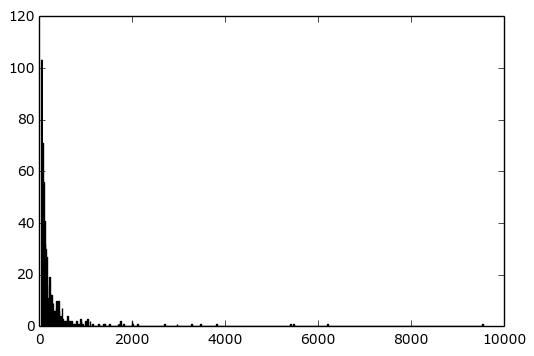

In [7]:
docs_per_label = code_to_num_of_docs.values()
docs_per_label = filter(lambda x: x > 49, docs_per_label)
docs_per_label.sort(reverse=True)
plt.hist(docs_per_label, bins=len(docs_per_label))
plt.show()

In [9]:
print len(docs_per_label)

598


In [10]:
labels_count = defaultdict(int)
for doc_labels in all_codes_per_doc:
    for label in doc_labels:
        labels_count[label] += 1
count_to_label = map(lambda label: (labels_count[label], label), labels_count.keys())
count_to_label.sort(reverse=True)
print '50 top labals', map(lambda x: x[1], count_to_label[:50])

50 top labals ['401.9', '414.01', '427.31', '428.0', '250.00', '272.0', '584.9', '518.81', '599.0', '530.81', '486', '272.4', '285.9', '496', '410.71', '507.0', '244.9', '285.1', '424.0', '276.2', '038.9', '997.1', '995.92', '412', '305.1', '424.1', '511.9', '411.1', '518.5', '276.5', '287.5', '403.91', '780.39', 'V45.81', '276.1', 'V58.61', '311', '585.9', '427.89', '427.1', '518.0', '785.52', '584.5', '493.90', '998.11', 'V45.82', '276.0', 'V15.82', '274.9', '998.12']


In [11]:
import nltk
import numpy as np
def dict_to_probfreq(d):
    d = nltk.FreqDist(d)
    return nltk.SimpleGoodTuringProbDist(d), d.keys()

def kl(p, q, keys):
    return sum(map(lambda i: p.prob(i)*np.log(p.prob(i)/q.prob(i)), keys))

In [35]:
mimic2_file = '/home/datasets/MIMIC/MIMIC2/MIMIC_PREPROCESSED'
mimic3_file = '/home/datasets/MIMIC/MIMIC3/MIMIC_PREPROCESSED'

mimic2 = defaultdict(int)
mimic3 = defaultdict(int)

for codes, tokens in mimic_doc_yielder(mimic2_file):
    for code in codes:
        mimic2[code] += 1

for codes, tokens in mimic_doc_yielder(mimic3_file):
    for code in codes:
        mimic3[code] += 1
        
d2, keys2 = dict_to_probfreq(mimic2)
d3, keys3 = dict_to_probfreq(mimic3)
keys = set(keys2+keys3)
print kl(d3, d2, keys)